# Introduction to Generative Adversarial Networks (GANs)

Generative Adversarial Networks (GANs) are a class of neural networks used to generate synthetic data. They are particularly popular for tasks like image generation, where the goal is to create realistic images from random noise.

---

## Key Components of a GAN

1. Generator (G):
   - Takes random noise $z$ as input.
   - Learns to generate fake images that resemble real images from the dataset.
   - Output: an image.

1. Discriminator (D):
   - Takes an image (real or fake) as input.
   - Learns to classify whether the image is real (from the dataset) or fake (from the generator).
   - Output: A single probability value (real or fake) or some score.

---

## How GANs Work
GANs consist of two neural networks that play a **min-max game**:
- The **Generator** tries to fool the Discriminator by creating images that look real.
- The **Discriminator** tries to distinguish between real and fake images.

## Training Objectives:
- **Discriminator**:
  - Maximizes the probability of correctly identifying real and fake images.
  - Uses, e.g., Binary Cross-Entropy (BCE) loss or Wasserstein loss.
  
- **Generator**:
  - Minimizes the Discriminator’s ability to classify generated images as fake.
  - Uses, e.g., Binary Cross-Entropy but flips the labels (fooling the Discriminator).


## Architecture (Schematic)

```python
# +-------------------------------+
# |       Generator (G)           |
# |   Input: Random Noise (z)     |
# +--------------+----------------+
#                |
#                v
# +-------------------------------+
# |   Transpose Convolutions      |
# |   + Activations (ReLU/Tanh)   |
# |   Output: Synthetic Image     |
# |                               |
# +--------------+----------------+
#                |
#         Fake Image (G(z))
#                |
# +--------------v----------------+
# |      Discriminator (D)        |
# |   Input: Real or Fake Image   |
# +--------------+----------------+
#                |
#                v
# +-------------------------------+
# |   Convolutions + Activations  |
# |         + Fully Connected     |
# |   Output: Real/Fake (0/1)     |
# +--------------+----------------+
#                |
#                v
#   Feedback to G (via Gradients)
```

## Explanation

**Generator (G):**

1. Takes a random noise vector $z$ as input.
1. Transposes convolutions and activations progressively upsample $z$ to produce a synthetic image.

**Discriminator (D):**

1. Takes an image (real or fake) as input.
1. Convolutions and fully connected layers classify the input as real or fake.

**Adversarial Training:**

The Discriminator learns to distinguish between real and fake images.
The Generator learns to produce images that can fool the Discriminator.

## Relation b/n GAN Generator vs. Decoder in Encoder-Decoder Architectures

| Feature                 | GAN Generator       | Decoder in Encoder-Decoder |
|-------------------------|---------------------|-----------------------------|
| **Input**               | Random noise sample $z$ | Latent vector from encoder  |
| **Output**              | Realistic image     | Reconstructed input         |
| **Deconvolution Usage** | Yes (to upsample)   | Yes (to upsample)           |
| **Encoder**             | Not present         | Present                     |
| **Latent Representation** | Sampled randomly   | Generated by the encoder    |

*Remarks*
- **GAN Generator ≈ Decoder**:
  - Both use deconvolution layers to generate high-dimensional outputs.
  - The *difference* lies in the source of the latent vector:
    - **GANs**: The latent vector is sampled from a random distribution (e.g., Gaussian).
    - **Encoder-Decoder**: The latent vector is produced by compressing input data via an encoder.


# Example

## Task

Augment a given dataset with artificially generated images.

## Dataset

Extracting dataset-part1.tar.gz...
Extracting dataset-part2.tar.gz...
Extracting dataset-part3.tar.gz...
Number of images aggregated: 29843
A sample batch of cat faces:


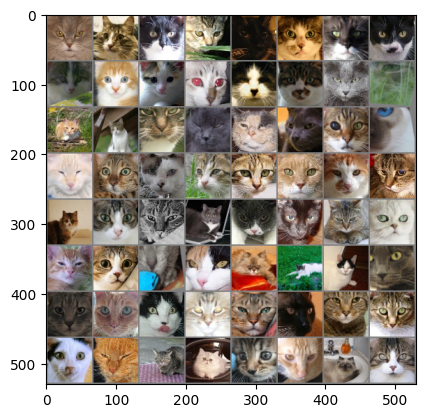

In [2]:
import os
import shutil
import urllib.request
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Base URL for the dataset parts
base_url = "https://github.com/fferlito/Cat-faces-dataset/raw/master/"
parts = ["dataset-part1.tar.gz", "dataset-part2.tar.gz", "dataset-part3.tar.gz"]
download_dir = "./cat_faces"
aggregated_dir = os.path.join(download_dir, "all_images")  # Directory to aggregate images

# Create directories if they don't exist
if not os.path.exists(download_dir):
    os.makedirs(download_dir)
if not os.path.exists(aggregated_dir):
    os.makedirs(aggregated_dir)

# Download, extract, and aggregate images
for part in parts:
    url = base_url + part
    download_path = os.path.join(download_dir, part)
    print(f"Downloading {part}...")
    urllib.request.urlretrieve(url, download_path)
    print(f"Extracting {part}...")
    with tarfile.open(download_path, "r:gz") as tar:
        tar.extractall(path=download_dir)
    os.remove(download_path)  # Remove the tar.gz file after extraction

# Collect all images into the aggregated directory
for subdir in ["dataset-part1", "dataset-part2", "dataset-part3"]:
    subdir_path = os.path.join(download_dir, subdir)
    for filename in os.listdir(subdir_path):
        file_path = os.path.join(subdir_path, filename)
        if os.path.isfile(file_path):
            shutil.move(file_path, os.path.join(aggregated_dir, filename))

# Count the number of images in the aggregated directory
num_images = len([name for name in os.listdir(aggregated_dir) if os.path.isfile(os.path.join(aggregated_dir, name))])
print(f"Number of images aggregated: {num_images}")

# Custom dataset for unstructured image data
class CatFacesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, fname))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Open image and ensure it's RGB
        if self.transform:
            image = self.transform(image)
        return image

# Define transformations and load the dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the custom dataset
dataset = CatFacesDataset(root_dir=aggregated_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Visualize a batch of images
def imshow(img):
    img = img * 0.5 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(dataloader)
images = next(dataiter)
print("A sample batch of cat faces:")
imshow(torchvision.utils.make_grid(images))

print("Credit: Federico Ferlito, https://github.com/fferlito")


## GAN Architecture

### Generator:
- Input: Noise vector $z$ of dimension $100$, say.
- Layers:
  - Transpose convolutions (deconvolutions) to upsample noise into an image.
  - Activations of choice
- Output: Image

## Discriminator:
- Input: Image
- Layers:
  - Convolutions to downsample the input.
  - Activations and normalizations of choice
- Output: Score or Probability (real or fake).

---

## Training Process

1. **Prepare the Dataset**:
   - Use images as real data for training the Discriminator.

1. **Train the Discriminator**:
   - Learn to classify real and fake images.
   - Loss: Binary Cross-Entropy or Wasserstein.

1. **Train the Generator**:
   - Learn to generate fake images that fool the Discriminator.
   - Loss: Binary Cross-Entropy (with flipped labels) or Wasserstein.

1. **Alternate Training**:
   - Train the Discriminator and Generator iteratively.


## Deconvolutions

A deconvolution layer (a.k.a. a transposed convolution layer) is used to upscale feature maps (i.e., increase their spatial resolution).

**In a regular convolution:**
The kernel slides over an input feature map, performs element-wise products, followed by summing up the result to produce a single "pixel" in the feature map.
**In a transposed convolution:**
The kernel slides over the output feature map and "projects" it back to a larger spatial dimension.

1. The kernel size determines the size of the region being "transposed."
1. The stride determines how much to "stretch" the feature map during the upsampling process.
1. Padding can be applied to ensure that the upscaled output has the desired dimensions (e.g., matching the original image size in a generator).

---

**Enlarging an Image**

Imagine blowing up a low-resolution image:
- Each pixel becomes a grid of smaller pixels.
- The values in the grid are derived from the kernel, blending neighboring pixels to create smoother transitions.


### Deconvolution Example

Consider a **deconvolution layer** with the following setup:

- **Input**: A feature map of size $ (1, 3, 4, 4) $ (batch size = 1, channels = 3, spatial dimensions = $ 4 \times 4 $).
- **Kernel Size**: $ 3 \times 3 $
- **Stride**: $ 2 $
- **Padding**: $ 1 $

**Steps:**
1. For each input pixel, the kernel creates a $ 3 \times 3 $ region in the output.
1. Adjacent regions overlap based on the stride, contributing to smoother transitions.
1. Padding ensures the output is larger than the input.

**Result:**
The output feature map has dimensions $ (1, 3, 8, 8) $, effectively doubling the spatial resolution.

### Application of Kernel to Feature Map Pixel Breakdown

1. **Input and Kernel Setup**:
   - **Input**: A single input pixel value, such as $x_{ij}$, from the feature map (at position $i, j$).
   - **Kernel**: A $3 \times 3$ matrix of learnable weights (e.g., $K$):

  $$
  K = \begin{bmatrix}
  k_{11} & k_{12} & k_{13} \\
  k_{21} & k_{22} & k_{23} \\
  k_{31} & k_{32} & k_{33}
  \end{bmatrix}
  $$

1. **Upsampling by Applying the Kernel**:
   - For every input pixel $x_{ij}$, the kernel $K$ is scaled (element-wise multiplied) by $x_{ij}$.
   - This produces a **$3 \times 3$ patch** in the output feature map.

   **Example**:
   If $x_{ij} = 2$, the resulting output patch is:
   $$
   2 \cdot K = \begin{bmatrix}
   2k_{11} & 2k_{12} & 2k_{13} \\
   2k_{21} & 2k_{22} & 2k_{23} \\
   2k_{31} & 2k_{32} & 2k_{33}
   \end{bmatrix}
   $$

1. **Mapping the Patch to the Output**:
   - The $3 \times 3$ patch is placed into the larger output feature map at the corresponding upscaled location.
   - If the **stride** is $2$, there will be gaps between adjacent patches. These gaps will be filled by subsequent overlapping patches from neighboring input pixels.

1. **Overlapping Regions**:
   - Adjacent $3 \times 3$ patches overlap due to the stride, and overlapping values are **summed** in the output feature map.
   - This blending serves a smooth transition between adjacent regions, reducing artifacts in the output.

1. **Padding**:
   - The padding ensures that the output is not smaller than the desired dimensions. For example:
     - Without padding, a $4 \times 4$ input with $3 \times 3$ kernel and stride $2$ would produce an $8 \times 8$ output.
     - Padding adds an extra border to ensure symmetry and desired size.

---

**Visual Representation of a Single Pixel's Expansion**

For an input feature map pixel $x_{ij}$, this is how the kernel $K$ maps its $3 \times 3$ region into the output:

Input pixel $x_{ij}$:  
$$
\begin{bmatrix}
\cdot & \cdot & \cdot \\
\cdot & x_{ij} & \cdot \\
\cdot & \cdot & \cdot
\end{bmatrix}
$$

Output $3 \times 3$ patch after applying kernel $K$:  
$$
\begin{bmatrix}
x_{ij} \cdot k_{11} & x_{ij} \cdot k_{12} & x_{ij} \cdot k_{13} \\
x_{ij} \cdot k_{21} & x_{ij} \cdot k_{22} & x_{ij} \cdot k_{23} \\
x_{ij} \cdot k_{31} & x_{ij} \cdot k_{32} & x_{ij} \cdot k_{33}
\end{bmatrix}
$$

---

**Output Shape**

After processing all input pixels:
- The output shape is determined by:
  $$
  \text{Output Size} = \text{Stride} \cdot (\text{Input Size} - 1) + \text{Kernel Size} - 2 \cdot \text{Padding}
  $$
- For our example with input size $4 \times 4$, kernel size $3$, stride $2$, and padding $1$, the output becomes:
  $$
  8 \times 8
  $$


## Generator

In [3]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels):
        super(Generator, self).__init__()

        # Fully connected layer to project latent vector
        self.fc = nn.Linear(latent_dim, 256 * 4 * 4)

        # Deconvolutional layers to upsample to 64x64
        self.deconv1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.relu1 = nn.ReLU()
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)   # 8x8 -> 16x16
        self.relu2 = nn.ReLU()
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)    # 16x16 -> 32x32
        self.relu3 = nn.ReLU()
        self.deconv4 = nn.ConvTranspose2d(in_channels=32, out_channels=img_channels, kernel_size=4, stride=2, padding=1)  # 32x32 -> 64x64
        self.tanh = nn.Tanh()  # Normalize outputs to [-1, 1]

    def forward(self, z):
        # Project and reshape the latent vector
        x = self.fc(z)
        x = x.view(x.size(0), 256, 4, 4)  # Reshape to (batch_size, channels, height, width)

        # Pass through deconvolutional layers
        x = self.relu1(self.deconv1(x))
        x = self.relu2(self.deconv2(x))
        x = self.relu3(self.deconv3(x))
        x = self.tanh(self.deconv4(x))
        return x

# Parameters for the Generator
latent_dim = 100  # Dimensionality of the latent space (input noise)
img_channels = 3  # Cat Faces images have 3 color channels (RGB)

# Instantiate the Generator model
generator = Generator(latent_dim, img_channels)

# Print the model to confirm setup
print(generator)

# Function to count the parameters of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count and print the number of parameters
generator_parameters = count_parameters(generator)
print(f"Number of trainable parameters in Generator: {generator_parameters}")


Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu1): ReLU()
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (deconv3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (deconv4): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (tanh): Tanh()
)
Number of trainable parameters in Generator: 1103587


### Rationale

Gradually upsmaple and transform random noise $z$ into a (hopefully) meaningful image.
Key building block: deconvolution layer.

### Architecture Schematic

```python
# +------------------------------------------+
# |                Input Layer               |
# |            Random Noise (z),             |
# |         Shape: (batch_size, 100)         |
# +--------------------+---------------------+
#                      |
#                      v
# +------------------------------------------+
# |          Fully Connected Layer           |
# |       fc: Linear(100 -> 256*4*4)         |
# | Output Shape: (batch_size, 256, 4, 4)    |
# +--------------------+---------------------+
#                      |
#                      v
# +------------------------------------------+
# |       Transpose Convolution Layer        |
# |    deconv1: ConvTranspose2d(256 -> 128)  |
# |     Kernel: 4x4, Stride: 2, Padding: 1   |
# | Output Shape: (batch_size, 128, 8, 8)    |
# +--------------------+---------------------+
#                      |
#                      v
# +------------------------------------------+
# |             ReLU Activation              |
# +--------------------+---------------------+
#                      |
#                      v
# +------------------------------------------+
# |       Transpose Convolution Layer        |
# |    deconv2: ConvTranspose2d(128 -> 64)   |
# |     Kernel: 4x4, Stride: 2, Padding: 1   |
# | Output Shape: (batch_size, 64, 16, 16)   |
# +--------------------+---------------------+
#                      |
#                      v
# +------------------------------------------+
# |             ReLU Activation              |
# +--------------------+---------------------+
#                      |
#                      v
# +------------------------------------------+
# |       Transpose Convolution Layer        |
# |    deconv3: ConvTranspose2d(64 -> 32)    |
# |     Kernel: 4x4, Stride: 2, Padding: 1   |
# | Output Shape: (batch_size, 32, 32, 32)   |
# +--------------------+---------------------+
#                      |
#                      v
# +------------------------------------------+
# |             ReLU Activation              |
# +--------------------+---------------------+
#                      |
#                      v
# +------------------------------------------+
# |       Transpose Convolution Layer        |
# |    deconv4: ConvTranspose2d(32 -> 3)     |
# |     Kernel: 4x4, Stride: 2, Padding: 1   |
# | Output Shape: (batch_size, 3, 64, 64)    |
# +--------------------+---------------------+
#                      |
#                      v
# +------------------------------------------+
# |             Tanh Activation              |
# |     Output normalized to [-1, 1]         |
# |    for RGB image generation              |
# +------------------------------------------+
```

## Discriminator

In [4]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.relu1 = nn.LeakyReLU(0.2)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)  # Batch normalization
        self.relu2 = nn.LeakyReLU(0.2)

        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.LeakyReLU(0.2)

        # Fourth convolutional layer
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.relu4 = nn.LeakyReLU(0.2)

        # Fully connected layer to output probability
        self.fc = nn.Linear(512 * 4 * 4, 1)  # Adjusted for 64x64 final spatial dimensions after pooling
        self.sigmoid = nn.Sigmoid()  # Outputs probability of being real or fake

    def forward(self, x):
        # Pass through the first convolutional layer and activation
        x = self.relu1(self.conv1(x))
        # Pass through the second convolutional layer, batch norm, and activation
        x = self.relu2(self.bn2(self.conv2(x)))
        # Pass through the third convolutional layer, batch norm, and activation
        x = self.relu3(self.bn3(self.conv3(x)))
        # Pass through the fourth convolutional layer, batch norm, and activation
        x = self.relu4(self.bn4(self.conv4(x)))
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        # Fully connected layer and sigmoid activation
        x = self.sigmoid(self.fc(x))
        return x

# Instantiate the discriminator model
discriminator = Discriminator()

# Print the model summary
print(discriminator)


Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu1): LeakyReLU(negative_slope=0.2)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.2)
  (fc): Linear(in_features=8192, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### Rationale

1. **Convolution Layers:**
Extract spatial features from the input images.
The feature maps progressively shrink in size as the spatial dimensions are reduced.

1. **Leaky ReLU:**
Provides non-linearity while avoiding issues like the dying ReLU problem (where neurons output 0 for all inputs).

1. **Batch Normalization:**
Stabilizes training by normalizing activations, allowing for higher learning rates.

1. **Fully Connected Layer:**
The flattened feature map is passed through a dense layer to output a single scalar.

1. **Sigmoid:**
Converts the scalar to a probability: close to 1 for real images and close to
0 for fake images.

### Leaky ReLU

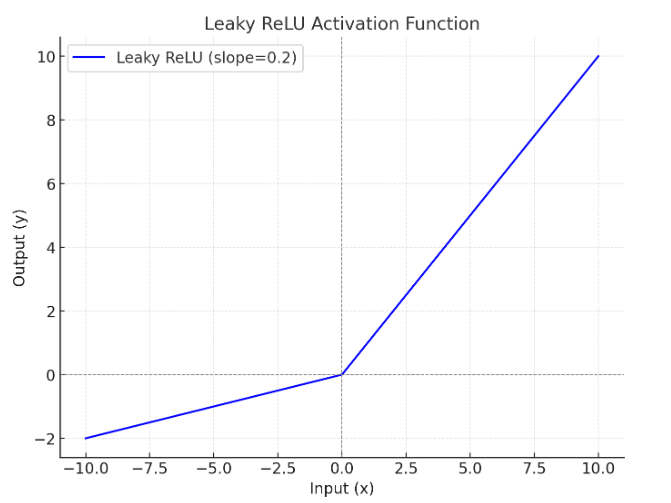

### Batch Normalization

Batch Normalization (BN) is a technique to improve the training of deep neural networks by normalizing the input to each layer for each mini-batch. This helps <u>stabilize and accelerate training</u> by reducing internal covariate shift, ensuring that the inputs to layers are on a consistent scale.

---

For a mini-batch $ x = \{x_1, x_2, \dots, x_m\} $ of size $ m $, BN applies the following steps to normalize and scale the inputs:

1. **Calculate the Mean and Variance**:
   For each feature (dimension), compute the mean and variance over the batch:
   $$
   \mu = \frac{1}{m} \sum_{i=1}^m x_i, \quad \sigma^2 = \frac{1}{m} \sum_{i=1}^m (x_i - \mu)^2
   $$

1. **Normalize the Inputs**:
   Center and scale each input:
   $$
   \hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \varepsilon}}
   $$
   Here, $ \varepsilon $ is a small constant added for numerical stability to avoid division by zero.

1. **Scale and Shift**:
   Apply learnable scaling and shifting parameters $ \gamma $ (scale) and $ \beta $ (shift):
   $$
   y_i = \gamma \hat{x}_i + \beta
   $$
   - $ \gamma $ and $ \beta $ are learned during training.
   - These parameters allow the network to undo normalization if necessary and adapt the distribution to better fit the task.

---

**Overall BN Formula**

The output $ y_i $ of batch normalization for each input $ x_i $ is:
$$
y_i = \gamma \cdot \frac{x_i - \mu}{\sqrt{\sigma^2 + \varepsilon}} + \beta
$$

---

**Remarks**

1. **Normalization**: The input features are rescaled to have zero mean and unit variance within the batch, making training more stable.
1. **Learnable Parameters**: $ \gamma $ and $ \beta $ allow the network to scale and shift the normalized values to learn the optimal distribution for the task.
1. **Efficiency**: BN reduces the need for careful initialization and higher learning rates can be used without risking instability.
1. **Faster Convergence**: BN allows higher learning rates and reduces training time.
1. **Regularization Effect**: It adds slight noise during training due to mini-batch statistics, reducing overfitting (but doesn't replace dropout entirely).
1. **Reduced Sensitivity**: The network becomes less sensitive to weight initialization and hyperparameter choices.

---

BN is typically added after the linear transformation of a layer but before the non-linear activation:
```python
# Example in PyTorch
x = self.fc1(x)             # Linear transformation
x = self.bn1(x)             # Batch normalization
x = F.relu(x)               # Non-linear activation
```

### Architecture Schematic

```python
# +------------------------------------------+
# |                Input Layer               |
# |       Image Input: (3 x 64 x 64)         |
# +--------------------+---------------------+
#                      |
#                      v
# +------------------------------------------+
# |          Convolutional Layer             |
# |     conv1: Conv2d(3 -> 64)               |
# |     Kernel: 4x4, Stride: 2, Padding: 1   |
# | Output Shape: (64, 16, 16)               |
# +--------------------+---------------------+
#                      |
#                      v
# +------------------------------------------+
# |          Leaky ReLU Activation           |
# |     Negative slope: 0.2                  |
# +--------------------+---------------------+
#                      |
#                      v
# +------------------------------------------+
# |          Convolutional Layer             |
# |     conv2: Conv2d(64 -> 128)             |
# |     Kernel: 4x4, Stride: 2, Padding: 1   |
# | Output Shape: (128, 8, 8)                |
# +--------------------+---------------------+
#                      |
#                      v
# +------------------------------------------+
# |         Batch Normalization              |
# +--------------------+---------------------+
#                      |
#                      v
# +------------------------------------------+
# |          Leaky ReLU Activation           |
# |     Negative slope: 0.2                  |
# +--------------------+---------------------+
#                      |
#                      v
# +------------------------------------------+
# |          Convolutional Layer             |
# |     conv3: Conv2d(128 -> 256)            |
# |     Kernel: 4x4, Stride: 2, Padding: 1   |
# | Output Shape: (256, 4, 4)                |
# +--------------------+---------------------+
#                      |
#                      v
# +------------------------------------------+
# |         Batch Normalization              |
# +--------------------+---------------------+
#                      |
#                      v
# +------------------------------------------+
# |          Leaky ReLU Activation           |
# |     Negative slope: 0.2                  |
# +--------------------+---------------------+
#                      |
#                      v
# +------------------------------------------+
# |             Fully Connected Layer        |
# |     fc: Linear(256 * 4 * 4 -> 1)         |
# | Output Shape: (batch_size, 1)            |
# +--------------------+---------------------+
#                      |
#                      v
# +------------------------------------------+
# |             Sigmoid Activation           |
# |    Outputs probability of real/fake      |
# +------------------------------------------+
```

## Loss (Binary Cross-Entropy)

In a GAN, **technically the same loss function** is used for both the generator and the discriminator, but the **interpretation and application differ**:

---

**Discriminator**

The discriminator is a binary classifier, and its goal is to correctly classify:
- **Real images** as $1$ (real).
- **Fake images** as $0$ (fake).

The **Binary Cross-Entropy Loss (BCELoss)** for the discriminator is computed as:
$$
\mathcal{L}_{D} = -\frac{1}{N} \sum_{i=1}^N \Big[ y_i \log(D(x_i)) + (1 - y_i) \log(1 - D(x_i)) \Big]
$$
where:
- $D(x_i)$: Discriminator's output for input $x_i$ (real or fake).
- $y_i$: Label ($1$ for real, $0$ for fake).

---

**Generator**

The generator is trained to **fool the discriminator**, so it wants the discriminator to classify its outputs (fake images) as $1$ (real).

To achieve this, the generator minimizes the **Binary Cross-Entropy Loss**, but only for the <u>discriminator's prediction on fake images</u>:
$$
\mathcal{L}_{G} = -\frac{1}{N} \sum_{i=1}^N \log(D(G(z_i)))
$$
- $G(z_i)$: Fake image generated from noise $z_i$.
- $D(G(z_i))$: Discriminator's prediction for the fake image.
- The target is $1$, as the generator wants fake images to be classified as real.

---

**Remarks**
- The discriminator improves by learning to distinguish real from fake.
- The generator improves by learning to make fake images more realistic, fooling the discriminator.

---

**Difference of Loss Usage for Generator and Discriminator**

The same **BCELoss** function is applied, but:
1. **Discriminator**: Minimizes its loss by correctly distinguishing real from fake.
2. **Generator**: Minimizes its loss by maximizing the discriminator’s confusion about fake images (making $D(G(z)) \to 1$).

This essentially describes an adversarial interplay.


## Loss (Wasserstein GAN)

The Wasserstein GAN (WGAN) introduces a loss function based on the <u>Earth Mover (EM) distance</u> (also called Wasserstein-1 distance).
This usually improves the stability of GAN training and reduces mode collapse.

In WGAN, the discriminator is called the **critic** because it no longer classifies images as real or fake (as in traditional GANs), but instead outputs a scalar "realness" score that measures how real the input appears.

---

**Discriminator (Critic) Loss**

The critic's goal is to maximize the difference between the average scores for real and fake images:
$$
\mathcal{L}_{D} = - \mathbb{E}_{x \sim p_{\text{real}}} [C(x)] + \mathbb{E}_{z \sim p_z} [C(G(z))]
$$
where:
- $C(x)$: Critic's score for a real image $x$.
- $C(G(z))$: Critic's score for a fake image generated by the generator $G$ from noise $z$.
- The critic aims to assign high scores to real images and low scores to fake images.
- $p_{\text{real}}$ is the distribution of the real images
- $p_z$ is the distribution of the input noise

---

**Generator Loss**

The generator's goal is to minimize the critic's score for fake images, effectively making them indistinguishable from real images:
$$
\mathcal{L}_{G} = - \mathbb{E}_{z \sim p_z} [C(G(z))]
$$
where:
- $C(G(z))$: Critic's score for a fake image.

By minimizing this loss, the generator tries to increase the critic's score for fake images, effectively making them look more real.

---

**Key Differences from Traditional GANs**

1. **No Sigmoid Activation in Critic**:
   - The critic directly outputs a scalar score, not a probability.
   - No binary cross-entropy loss is used.

1. **Weight Clipping**:
   - To enforce the Lipschitz continuity constraint, the critic's weights are clamped to a small range (e.g., $[-0.01, 0.01]$) after each update.

1. **Interpretation**:
   - The loss values are not probabilities and cannot be interpreted as such.
   - Instead, the loss reflects how well the critic can distinguish real from fake images and how well the generator fools the critic.

---

**Training Process**

1. **Critic Training**:
   - The critic is trained for multiple steps per generator step (e.g., 5 steps) to ensure it provides meaningful feedback to the generator.

1. **Generator Training**:
   - The generator is trained to increase the critic's score for fake images.

---

**Final Remarks**

1. More stable training compared to the case of BCE.
2. Loss values correlate better with the quality of generated images.
3. Reduces mode collapse compared to traditional GANs.


## Training (Using Binary Cross-Entropy Loss)

Using device: cpu


Epoch 1/20: 100%|██████████| 467/467 [17:54<00:00,  2.30s/it, d_loss=0.394, g_loss=2.64]


Epoch 1/20, Avg Discriminator Loss: 0.2063, Avg Generator Loss: 5.3284
Generated images after Epoch 1:


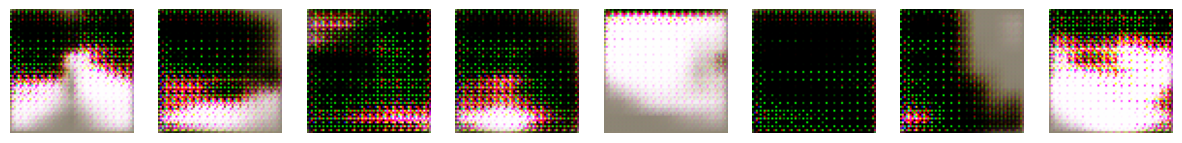

Epoch 2/20: 100%|██████████| 467/467 [18:08<00:00,  2.33s/it, d_loss=0.548, g_loss=2.1]


Epoch 2/20, Avg Discriminator Loss: 0.2554, Avg Generator Loss: 4.1056
Generated images after Epoch 2:


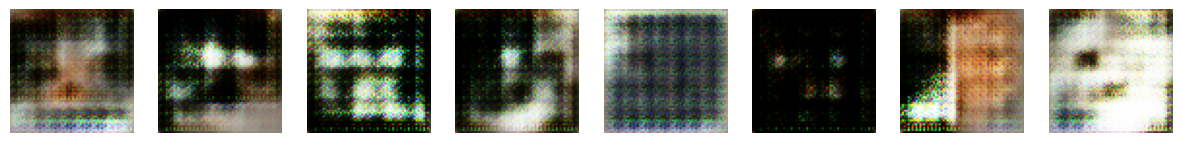

Epoch 3/20: 100%|██████████| 467/467 [18:08<00:00,  2.33s/it, d_loss=0.948, g_loss=4.71]


Epoch 3/20, Avg Discriminator Loss: 0.3764, Avg Generator Loss: 3.3202
Generated images after Epoch 3:


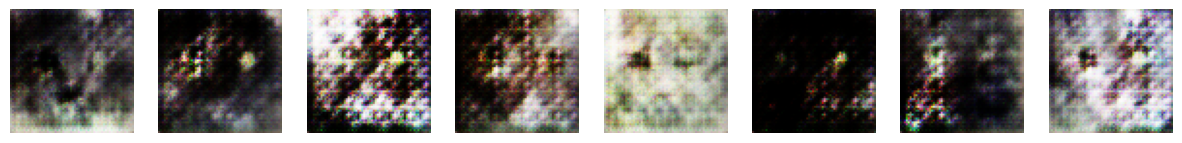

Epoch 4/20: 100%|██████████| 467/467 [17:59<00:00,  2.31s/it, d_loss=0.759, g_loss=4.9]


Epoch 4/20, Avg Discriminator Loss: 0.3637, Avg Generator Loss: 3.4687
Generated images after Epoch 4:


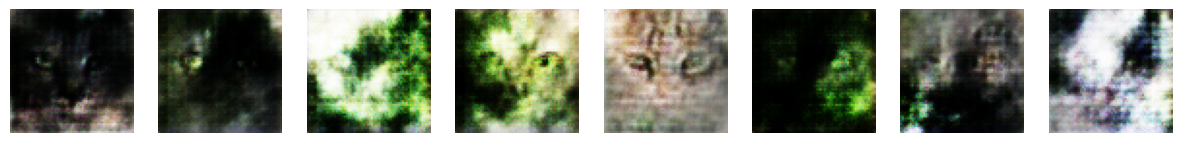

Epoch 5/20: 100%|██████████| 467/467 [17:43<00:00,  2.28s/it, d_loss=0.719, g_loss=3.52]


Epoch 5/20, Avg Discriminator Loss: 0.3731, Avg Generator Loss: 3.2806
Generated images after Epoch 5:


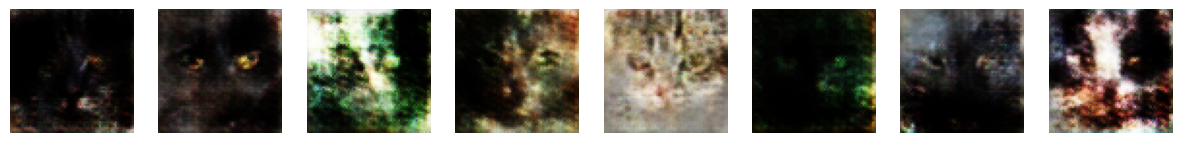

Epoch 6/20: 100%|██████████| 467/467 [17:44<00:00,  2.28s/it, d_loss=0.585, g_loss=3.27]


Epoch 6/20, Avg Discriminator Loss: 0.3573, Avg Generator Loss: 3.1766
Generated images after Epoch 6:


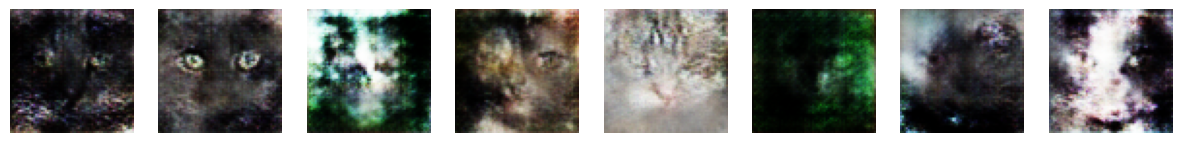

Epoch 7/20:  69%|██████▊   | 320/467 [12:22<04:54,  2.00s/it, d_loss=0.617, g_loss=3.63]

In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

from tqdm import tqdm

# Define the loss function for the GAN
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Parameters
num_epochs = 20
z_dim = 100  # Dimensionality of the noise vector
real_label = 0.9  # For label smoothing
fake_label = 0.0
discriminator_update_frequency = 2  # Update discriminator every 2 batches

# Initialize models
generator = Generator(latent_dim=z_dim, img_channels=3).to(device)
discriminator = Discriminator().to(device)

# Define optimizers
lr_generator = 0.0002
lr_discriminator = 0.0002
beta1, beta2 = 0.5, 0.999
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr_generator, betas=(beta1, beta2))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr_discriminator, betas=(beta1, beta2))

# Function to visualize generated images with a fixed random seed
def visualize_generated_images(generator, device, z_dim, num_images=8, fixed_seed=42):
    generator.eval()
    with torch.no_grad():
        torch.manual_seed(fixed_seed)
        z = torch.randn(num_images, z_dim, device=device)
        fake_images = generator(z).cpu()
        fake_images = (fake_images * 0.5 + 0.5).clamp(0, 1)

        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        for i in range(num_images):
            axes[i].imshow(fake_images[i].permute(1, 2, 0))
            axes[i].axis('off')
        plt.show()

# Training loop
for epoch in range(num_epochs):
    running_loss_discriminator = 0.0
    running_loss_generator = 0.0

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, real_images in progress_bar:
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # -----------------------
        # Train Discriminator
        # -----------------------
        if batch_idx % discriminator_update_frequency == 0:
            z = torch.randn(batch_size, z_dim, device=device)
            fake_images = generator(z)

            real_labels = torch.full((batch_size, 1), real_label, device=device)
            fake_labels = torch.full((batch_size, 1), fake_label, device=device)

            outputs_real = discriminator(real_images)
            loss_real = criterion(outputs_real, real_labels)

            outputs_fake = discriminator(fake_images.detach())
            loss_fake = criterion(outputs_fake, fake_labels)

            loss_discriminator = loss_real + loss_fake

            optimizer_discriminator.zero_grad()
            loss_discriminator.backward()
            optimizer_discriminator.step()

            running_loss_discriminator += loss_discriminator.item()

        # -----------------------
        # Train Generator
        # -----------------------
        z = torch.randn(batch_size, z_dim, device=device)
        fake_images = generator(z)

        outputs_fake = discriminator(fake_images)
        loss_generator = criterion(outputs_fake, real_labels)

        optimizer_generator.zero_grad()
        loss_generator.backward()
        optimizer_generator.step()

        running_loss_generator += loss_generator.item()

        # Update progress bar
        progress_bar.set_postfix(d_loss=loss_discriminator.item(), g_loss=loss_generator.item())

    # Print average losses for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Avg Discriminator Loss: {running_loss_discriminator/len(dataloader):.4f}, Avg Generator Loss: {running_loss_generator/len(dataloader):.4f}")

    # Visualize generated images after each epoch
    print(f"Generated images after Epoch {epoch+1}:")
    visualize_generated_images(generator, device, z_dim, num_images=8, fixed_seed=42)

print("GAN Training Complete!")


## Training (Using Wasserstein GAN)

### Critic Model (Former Discriminator)

In [5]:
import torch.nn as nn

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.relu1 = nn.LeakyReLU(0.2)

        # Second convolutional layer (with LayerNorm instead of BatchNorm)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.ln2 = nn.LayerNorm([128, 16, 16])
        self.relu2 = nn.LeakyReLU(0.2)

        # Third convolutional layer (with LayerNorm instead of BatchNorm)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.ln3 = nn.LayerNorm([256, 8, 8])
        self.relu3 = nn.LeakyReLU(0.2)

        # Fully connected layer to output raw scores
        self.fc = nn.Linear(256 * 8 * 8, 1)

    def forward(self, x):
        # Pass through the first convolutional layer and activation
        x = self.relu1(self.conv1(x))
        # Pass through the second convolutional layer, layer norm, and activation
        x = self.relu2(self.ln2(self.conv2(x)))
        # Pass through the third convolutional layer, layer norm, and activation
        x = self.relu3(self.ln3(self.conv3(x)))
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        # Fully connected layer
        x = self.fc(x)
        return x

# Instantiate the critic model
critic = Critic()

# Print the model summary
print(critic)


Critic(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu1): LeakyReLU(negative_slope=0.2)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (ln2): LayerNorm((128, 16, 16), eps=1e-05, elementwise_affine=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (ln3): LayerNorm((256, 8, 8), eps=1e-05, elementwise_affine=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc): Linear(in_features=16384, out_features=1, bias=True)
)


### Training Loop

Using device: cpu


Epoch 1/20: 100%|██████████| 467/467 [56:20<00:00,  7.24s/it, d_loss=-3.12, g_loss=1.58]


Epoch 1/20, Avg Critic Loss: -0.5414, Avg Generator Loss: 1.3688
Generated images after Epoch 1:


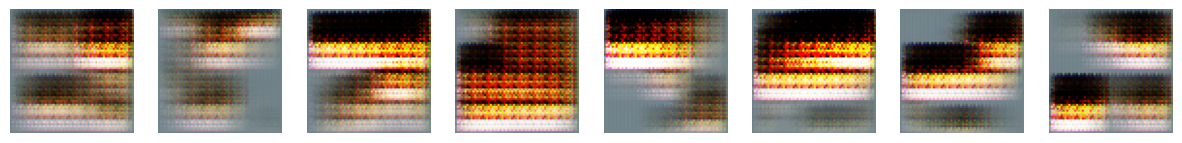

Epoch 2/20:  92%|█████████▏| 429/467 [51:21<04:32,  7.18s/it, d_loss=-3.22, g_loss=1.62]


KeyboardInterrupt: 

In [6]:
import torch
from tqdm import tqdm

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Dimensionality of the noise vector
z_dim = 100

# Initialize models on GPU, if possible
generator = Generator(latent_dim=z_dim, img_channels=3).to(device)
critic = Critic().to(device)

# Define optimizers
lr = 0.00005
beta1 = 0.5
beta2 = 0.999
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_critic = torch.optim.Adam(critic.parameters(), lr=lr, betas=(beta1, beta2))

# Training parameters
num_epochs = 20
n_critic = 5  # Number of critic updates per generator update
weight_clip = 0.01  # Weight clipping parameter

# Function to visualize generated images with a fixed random seed
def visualize_generated_images(generator, device, z_dim, num_images=8, fixed_seed=42):
    generator.eval()  # Set the generator to evaluation mode
    with torch.no_grad():
        # Set a fixed random seed for reproducibility
        torch.manual_seed(fixed_seed)
        z = torch.randn(num_images, z_dim, device=device)
        fake_images = generator(z).cpu()
        fake_images = (fake_images * 0.5 + 0.5).clamp(0, 1)  # Denormalize to [0, 1]

        # Plot the generated images
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        for i in range(num_images):
            axes[i].imshow(fake_images[i].permute(1, 2, 0))  # Convert from CHW to HWC
            axes[i].axis('off')
        plt.show()

# Training loop
for epoch in range(num_epochs):
    running_loss_generator = 0.0
    running_loss_critic = 0.0
    total_critic_updates = 0  # Track the number of critic updates for proper averaging

    # Initialize progress bar
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, real_images in progress_bar:
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # -----------------------
        # Train Critic
        # -----------------------
        critic_loss_batch = 0.0  # Reset batch-level critic loss for this iteration
        for _ in range(n_critic):
            z = torch.randn(batch_size, z_dim, device=device)
            fake_images = generator(z)

            # Critic loss on real images
            outputs_real = critic(real_images)
            loss_real = -torch.mean(outputs_real)

            # Critic loss on fake images
            outputs_fake = critic(fake_images.detach())  # Detach to avoid training the generator while training the critic
            loss_fake = torch.mean(outputs_fake)

            # Total critic loss
            critic_loss = loss_real + loss_fake

            # Backward pass and optimization for critic
            optimizer_critic.zero_grad()
            critic_loss.backward()
            optimizer_critic.step()

            # Weight clipping for Lipschitz constraint
            for param in critic.parameters():
                param.data.clamp_(-weight_clip, weight_clip)

            # Accumulate critic loss
            critic_loss_batch += critic_loss.item()
            total_critic_updates += 1  # Increment total critic updates

        # Average critic loss for this batch (across `n_critic` updates)
        running_loss_critic += critic_loss_batch / n_critic

        # -----------------------
        # Train Generator
        # -----------------------
        z = torch.randn(batch_size, z_dim, device=device)
        fake_images = generator(z)

        # Generator loss
        outputs_fake = critic(fake_images)
        generator_loss = -torch.mean(outputs_fake)

        # Backward pass and optimization for generator
        optimizer_generator.zero_grad()
        generator_loss.backward()
        optimizer_generator.step()

        # Accumulate generator loss
        running_loss_generator += generator_loss.item()

        # Update progress bar with the most recent critic and generator loss
        progress_bar.set_postfix(d_loss=critic_loss.item(), g_loss=generator_loss.item())

    # Print average losses for the epoch
    avg_critic_loss = running_loss_critic / total_critic_updates
    avg_generator_loss = running_loss_generator / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg Critic Loss: {avg_critic_loss:.4f}, Avg Generator Loss: {avg_generator_loss:.4f}")

    # Visualize generated images after each epoch with fixed seed
    print(f"Generated images after Epoch {epoch+1}:")
    visualize_generated_images(generator, device, z_dim, num_images=8, fixed_seed=42)

print("WGAN Training Complete!")


## Visual Assessment of Generated Images

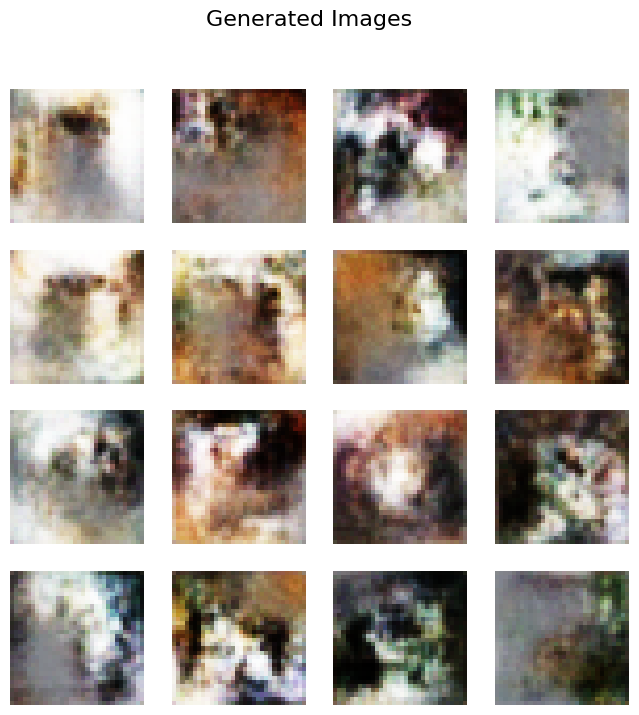

In [ ]:
import matplotlib.pyplot as plt

def visualize_generated_images(generator, z_dim, num_images=16, device='cuda'):
    """
    Visualize generated images from the generator.
    """
    # Set the generator to evaluation mode
    generator.eval()

    # Generate random noise as input for the generator
    with torch.no_grad():  # No gradient calculation during evaluation
        z = torch.randn(num_images, z_dim, device=device)
        fake_images = generator(z).cpu()  # Generate fake images and move them to CPU

    # Unnormalize the images (assuming [-1, 1] range from Tanh activation)
    fake_images = (fake_images + 1) / 2

    # Plot the generated images
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)  # Create a grid of 4x4 images
        plt.imshow(fake_images[i].permute(1, 2, 0).numpy())  # Convert tensor to image format
        plt.axis('off')
    plt.suptitle("Generated Images", fontsize=16)
    plt.show()

# Example: Visualize generated images after a few epochs
visualize_generated_images(generator, z_dim=100, num_images=16, device=device)
